Download the GloVe embeddings needed from here:
https://nlp.stanford.edu/projects/glove/
Filename is: glove.6B.50d.txt

The review files are available but you can also download them from here:
https://archive.ics.uci.edu/ml/machine-learning-databases/00331/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier


import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

#word2vec
from gensim.models import Word2Vec  
import gensim
import string

Using TensorFlow backend.
[nltk_data] Downloading package wordnet to /home/typedoor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Part A: Necessary imports and functions to be used, Loading the data

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [3]:
PATH = '/home/typedoor/PLBRS/Data/'

In [4]:

#This is a function that reads a pre-trained embeddings file and returns a matrix embeddings for the dataset we are working with.
#Inputs are the filepath, the size of the embeddings (should match the pre-trained ones) and the word_indices as created by a tokenizer on our data
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [5]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

In [99]:
simpsons = pd.read_csv(PATH + 'simpson_family_sentence_by_sentence.csv')
simpsons.Character = simpsons.Character.map({'Homer Simpson' : 0, 'Marge Simpson' : 1, 'Lisa Simpson' : 2, 'Bart Simpson' : 3})
simpsons.Line[:10]

0                               Where's Mr. Bergstrom?
1                           That life is worth living.
2                       Victory party under the slide!
3                                       Mr. Bergstrom!
4                                       Mr. Bergstrom!
5                  Do you know where I could find him?
6    The train, how like him... traditional, yet en...
7                           I see he touched you, too.
8                      Hey, thanks for your vote, man.
9                            Well, you got that right.
Name: Line, dtype: object

In [100]:
stop_words = set(stopwords.words('english'))

ps = PorterStemmer()
lem = WordNetLemmatizer()

def remove_stop_words(line):
    result = ''
    for word in line.lower().split():
        if word not in stop_words:
            result = result + " " + word
    
    return result
    #return " ".join(filtered_line)

def stemm_words(line):
    result = ''
    
    for word in line.split():
        result = result + " " + ps.stem(word)
    
    return result
    #return "".join(stemmed_line)

def lemmatize_words(line):
    result = ''
    
    for word in line.split():
        result = result + ' ' + lem.lemmatize(word)
     
    return result

    #return "".join(lemmed_line)

In [101]:
simpsons.Line = simpsons.Line.apply(remove_stop_words)
simpsons.Line = simpsons.Line.apply(stemm_words)
simpsons.Line = simpsons.Line.apply(lemmatize_words)
simpsons.Line[:10]

0                                where' mr. bergstrom?
1                                   life worth living.
2                                 victori parti slide!
3                                       mr. bergstrom!
4                                       mr. bergstrom!
5                                 know could find him?
6     train, like him... traditional, yet environme...
7                                  see touch you, too.
8                                hey, thank vote, man.
9                                     well, got right.
Name: Line, dtype: object

### Part B: Defining a baseline model

In [7]:
from sklearn.model_selection import train_test_split

sentences = simpsons['Line'].values  # text input (X)
y = simpsons['Character'].values     # labels

#split to train/test
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000,stratify = y)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

#Build simple counts
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [9]:
from sklearn.linear_model import LogisticRegression

#Try a simple classifier
clf = LogisticRegression(solver='lbfgs', max_iter = 1000,class_weight = 'balanced')
clf.fit(X_train, y_train)


predicted= clf.predict(X_test)
confusion = metrics.confusion_matrix(y_test, predicted)
cm = metrics.classification_report(y_test, predicted)
print("RF Accuracy:",metrics.accuracy_score(y_test, predicted))
print(confusion)
print(cm)

/home/typedoor/anaconda3/envs/umc/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


RF Accuracy: 0.44697928198639886
[[5864 2178 1567 2011]
 [1291 2152  808  573]
 [ 965  751 1588  714]
 [1511  671  947 1701]]
              precision    recall  f1-score   support

           0       0.61      0.50      0.55     11620
           1       0.37      0.45      0.41      4824
           2       0.32      0.40      0.36      4018
           3       0.34      0.35      0.35      4830

   micro avg       0.45      0.45      0.45     25292
   macro avg       0.41      0.42      0.42     25292
weighted avg       0.47      0.45      0.45     25292




The following does the same for the all three datasets

In [8]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression(solver='lbfgs')
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


Let's try the same dataset with a simple feed-forward Neural Network

In [17]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features to be used --> input to the NN

#A simple neural network with 10 hidden units, Relu activation and an output neuron - sigmoid, since we are doing binary classification
#See below comment on how we could do the same with a softmax in order to do multi-class classification
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))

#There is a warning in running this, i think that it will be fixed with the next release of tensorflow

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [12]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9964
Testing Accuracy:  0.7754


In [ ]:
plot_history(history)

In case of multi-class classification, we need to replace the final layer with softmax. In this case, we need to "modify" the output so that it can handle the different categories. See the code below.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 10)                206710    
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 44        
Total params: 206,754
Trainable params: 206,754
Non-trainable params: 0
_________________________________________________________________
Train on 75875 samples, validate on 25292 samples
Epoch 1/10
75875/75875 [==============================] - 65s 850us/step - loss: 1.1795 - acc: 0.4977 - val_loss: 1.1435 - val_acc: 0.5136
Epoch 2/10
75875/75875 [==============================] - 87s 1ms/step - loss: 1.0644 - acc: 0.5497 - val_loss: 1.1496 - val_acc: 0.5136
Epoch 3/10
75875/75875 [==============================] - 70s 928us/step - loss: 0.9964 - acc: 0.5843 - val_loss: 1.1788 - val_acc: 0.5087
Epoch 4/10
75875/75875 [==============================] - 67s 885us

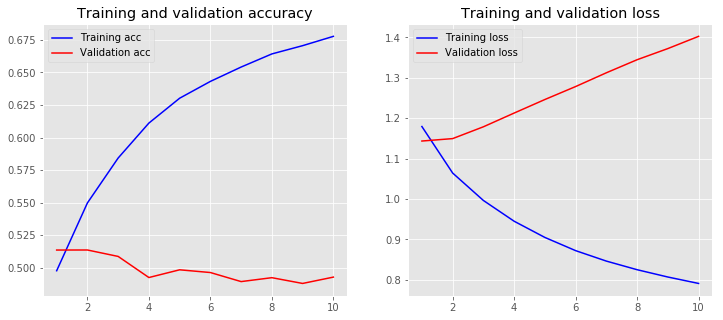

In [22]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train2 = onehot_encoder.fit_transform(y_train.reshape(len(y_train),1))
y_test2 = onehot_encoder.fit_transform(y_test.reshape(len(y_test),1))

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))     #Notice the change now

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   #Notice the change now
model.summary()

history = model.fit(X_train, y_train2,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test2),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train2, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

### Part C: Let's start using Word Embeddings

#### C1: Let's load pre-Trained Word Embeddings

In [51]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 25#arbitrary

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt',tokenizer.word_index, embedding_dim)

embedding_matrix.shape

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

#### C2. CNN with trainable embeddings

Remember that embeddings can be learned through the network. In the following example we train a CNN where the first layer is actually learning (from scratch) the word vectors for each word. 

In [54]:
maxlen = 25
embedding_dim = 25

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 25, 25)            539175    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 21, 128)           16128     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 44        
Total params: 556,637
Trainable params: 556,637
Non-trainable params: 0
_________________________________________________________________


**SELF TRAINED WORD VECTORS** 

Train on 75875 samples, validate on 25292 samples
Epoch 1/5
75875/75875 [==============================] - 182s 2ms/step - loss: 1.1785 - acc: 0.4968 - val_loss: 1.1487 - val_acc: 0.5086
Epoch 2/5
75875/75875 [==============================] - 152s 2ms/step - loss: 1.0585 - acc: 0.5542 - val_loss: 1.1494 - val_acc: 0.5092
Epoch 3/5
75875/75875 [==============================] - 142s 2ms/step - loss: 0.9360 - acc: 0.6224 - val_loss: 1.2096 - val_acc: 0.5082
Epoch 4/5
75875/75875 [==============================] - 132s 2ms/step - loss: 0.8231 - acc: 0.6728 - val_loss: 1.2856 - val_acc: 0.4917
Epoch 5/5
75875/75875 [==============================] - 134s 2ms/step - loss: 0.7268 - acc: 0.7118 - val_loss: 1.3931 - val_acc: 0.4919
Training Accuracy: 0.7686
Testing Accuracy:  0.4919


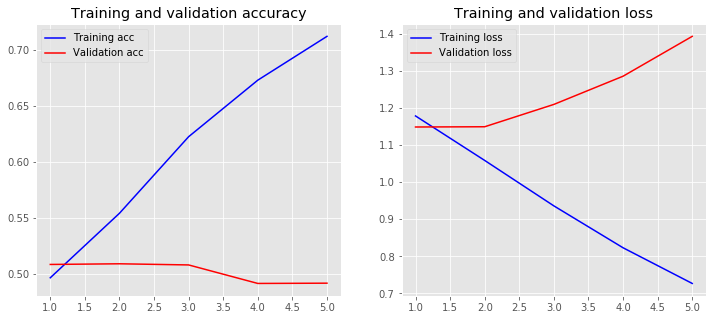

In [55]:
history = model.fit(X_train, y_train2,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test2),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train2, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [62]:
prediction = model.predict(X_train[:10])
print(prediction)
print(sentences_test[:10])
print(y_test2[:10])

[[1.76356703e-01 7.79756665e-01 4.27902639e-02 1.09635713e-03]
 [7.75391459e-01 7.42681697e-02 1.99628714e-02 1.30377546e-01]
 [8.54171932e-01 1.05350763e-01 3.49833891e-02 5.49397152e-03]
 [9.47213411e-01 3.20764706e-02 3.26208817e-03 1.74481124e-02]
 [1.46466941e-01 2.85992841e-03 2.68083010e-02 8.23864818e-01]
 [8.62635970e-01 7.15866452e-03 1.29261995e-02 1.17279127e-01]
 [5.66804051e-01 2.85731908e-02 9.23204143e-03 3.95390630e-01]
 [9.99182642e-01 4.71318548e-04 2.94297934e-04 5.17093213e-05]
 [9.77688134e-01 1.88097265e-02 9.60328442e-04 2.54181703e-03]
 [4.25725788e-01 2.00728536e-01 2.17895359e-01 1.55650273e-01]]
['Maybe I should come forward.'
 "First, it's fudge-cicle... And I know they're up there."
 "If I get really scared, I don't want to ruin the suit."
 'But do you know how ridiculous you look right now?'
 'You brought a whole beer keg.' 'What should we do until you get back?'
 'Take out the garbage.' 'I sure have.'
 'Everyone in that live studio audience is dead now.'

#### C3: Let's use the pre-trained embeddings we loaded before!

In the first case, we are going to use the matrix as is and set trainable parameter to False. This will not allow the word embeddings to be updated during training

In [ ]:
embedding_dim=50
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen,trainable=False))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Let's redo the training but this time let the embeddings adapt to the training set

In [ ]:
embedding_dim=50
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen,trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train2,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test2),
                    batch_size=5)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Improvement jumps a bit!

Depending on your dataset, your domain (and your experience), you might want to:

(a) use pre-trained word embeddings (no adjustments)

(b) use pre-trained word embeddings and fine-tune them on your dataset

(c) train the embeddings on your dataset

#### C4: LSTM

In this case and probably due to the small-size of the dataset, LSTM performs poorly. Also note, that LSTM training takes way longer than CNN. Notice the number of parameters we need to train in each case.

Training Accuracy: 0.9982
Testing Accuracy:  0.7701


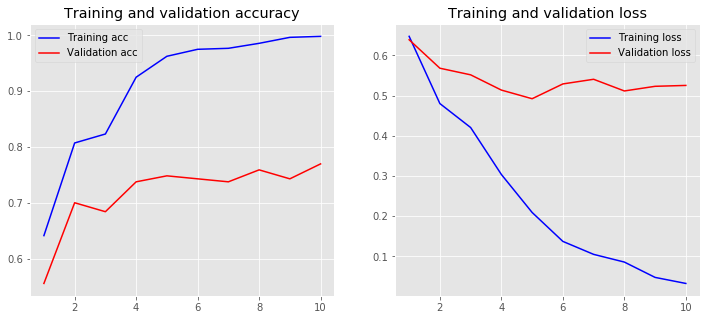

In [26]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 50)           128750    
_________________________________________________________________
lstm_1 (LSTM)                (None, 56)                23968     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 57        
Total params: 152,775
Trainable params: 152,775
Non-trainable params: 0
_________________________________________________________________
Train on 561 samples, validate on 187 samples
Epoch 1/10
561/561 [==============================] - 17s 30ms/step - loss: 0.6935 - acc: 0.4973 - val_loss: 0.6928 - val_acc: 0.4920
Epoch 2/10
561/561 [==============================] - 15s 26ms/step - loss: 0.6929 

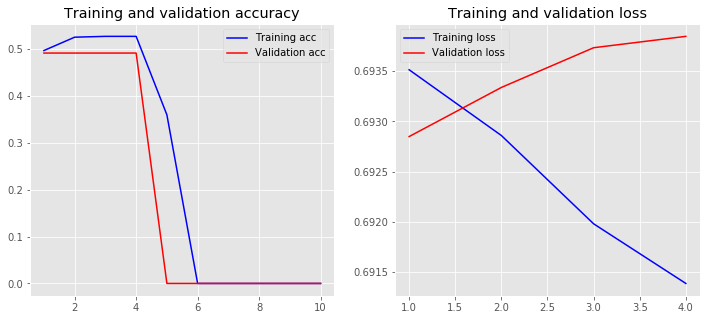

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

embedding_dim = 50
model = Sequential()
#model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.LSTM(56, activation='relu',dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

This is a bigger dataset (available via Keras), and most suitable for LSTM.

**Attention: This will take some time to run**

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 209s 8ms/step - loss: 0.4452 - acc: 0.7867 - val_loss: 0.3329 - val_acc: 0.8617
Epoch 2/3
25000/25000 [==============================] - 215s 9ms/step - loss: 0.2824 - acc: 0.8877 - val_loss: 0.3206 - val_acc: 0.8689
Epoch 3/3
25000/25000 [==========================

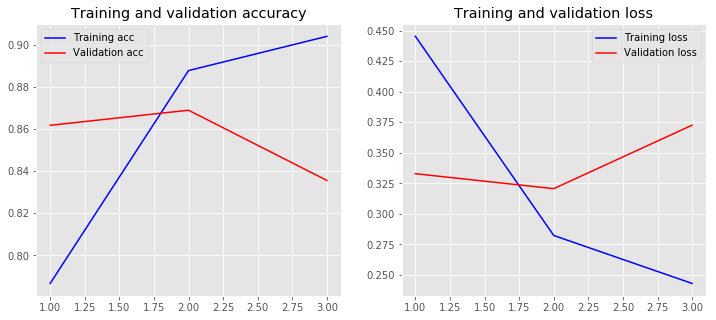

In [29]:
from keras.datasets import imdb

from keras.preprocessing import sequence

# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

# create the model
model = Sequential()
#this won't work, because our loaded-data do not have the same match with the keras dataset we loaded
#model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(Embedding(top_words, embedding_dim, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

history=model.fit(X_train, y_train, epochs=3, batch_size=64,validation_data=(X_test, y_test))

# Final evaluation of the model
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)